# Análise de Planos de Telefonia

Você está atuando como analista na empresa de telecomunicações Megaline. A Megaline oferece três tipos de planos aos seus clientes: Pré-pago, Surf e Ultimate. O departamento de marketing deseja otimizar o orçamento de publicidade, e para isso, precisa identificar quais dos planos são os mais lucrativos. Você ficará encarregado de conduzir uma análise inicial com base em uma amostra de 500 clientes da Megaline. Os dados incluem informações sobre a identidade dos clientes, suas localizações, o plano que utilizam, bem como o número de chamadas efetuadas e mensagens enviadas em 2018. Sua responsabilidade é analisar o comportamento desses clientes e determinar quais dos planos pré-pagos geram a maior receita para a empresa.

## Iniciação

In [1]:
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st
from functools import reduce
import math

### Carregando dados

In [2]:
try:
    calls = pd.read_csv('megaline_calls.csv')
    messages = pd.read_csv('megaline_messages.csv')
    internet = pd.read_csv('megaline_internet.csv')
    users = pd.read_csv('megaline_users.csv')
    plans = pd.read_csv('megaline_plans.csv')
except:
    calls = pd.read_csv('/datasets/megaline_calls.csv')
    messages = pd.read_csv('/datasets/megaline_messages.csv')
    internet = pd.read_csv('/datasets/megaline_internet.csv')
    users = pd.read_csv('/datasets/megaline_users.csv')
    plans = pd.read_csv('/datasets/megaline_plans.csv')

### Obtendo informações gerais e tratando os valores

De `calls`

In [3]:
calls.info()
calls.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


Aqui notamos que não há valores ausentes

Agora podemos obter informações mais relevantes com os dados agrupando as colunas por `user_ID` e criando colunas que calculam a duração, a média e a quantidade das chamadas por usuário.

In [4]:
processed_calls = calls[calls['duration']> 0]
processed_calls.info()

grouped_calls = processed_calls.groupby('user_id',as_index=False).agg({'duration': 'sum', 'call_date': 'count'})

grouped_calls.columns = ['user_id', 'duration','calls']

grouped_calls['avg_duration_per_month'] = grouped_calls['duration']/12
grouped_calls['avg_calls_per_month'] = grouped_calls['calls']/12

grouped_calls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110901 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         110901 non-null  object 
 1   user_id    110901 non-null  int64  
 2   call_date  110901 non-null  object 
 3   duration   110901 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,user_id,duration,calls,avg_duration_per_month,avg_calls_per_month
0,1000,116.83,16,9.735833,1.333333
1,1001,1640.46,202,136.705000,16.833333
2,1002,777.13,94,64.760833,7.833333
3,1003,1041.00,118,86.750000,9.833333
4,1004,2618.95,306,218.245833,25.500000
...,...,...,...,...,...
476,1495,1666.41,208,138.867500,17.333333
477,1496,1376.21,158,114.684167,13.166667
478,1497,276.53,42,23.044167,3.500000
479,1498,3029.97,371,252.497500,30.916667


De `messages`

In [5]:
messages.info()
messages.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
5,1000_346,1000,2018-12-29
6,1000_386,1000,2018-12-30
7,1000_413,1000,2018-12-31
8,1000_502,1000,2018-12-27
9,1000_525,1000,2018-12-28


Também não possui valores ausentes.

Será feito os mesmos procedimentos que no anterior, porém com menos calculos devido a quantidade de informações disponíveis. Este será agrupado por `user_ID`, contado o número de mensagens e a média por mês.

In [6]:
grouped_messages = messages.groupby('user_id').size().reset_index(name='total_texts')

grouped_messages['avg_texts_per_month'] = grouped_messages['total_texts']/12
grouped_messages

,user_id,total_texts,avg_texts_per_month
0,1000,11,0.916667
1,1001,207,17.250000
2,1002,88,7.333333
3,1003,50,4.166667
4,1004,177,14.750000
...,...,...,...
397,1491,409,34.083333
398,1492,108,9.000000
399,1494,174,14.500000
400,1496,65,5.416667


De `internet`

In [7]:
internet.info()
internet.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


Não possui valores ausentes

O agrupamento será pela coluna `user_ID` e definiremos a quantidade total de megabytes, `Mb`, e a média mensal.

In [8]:
processed_data_usage = internet[internet['mb_used']> 0]
processed_data_usage.info()

grouped_data_usage = processed_data_usage.groupby('user_id',as_index=False).agg({'mb_used': 'sum'})

grouped_data_usage.columns = ['user_id', 'total_mb_used']
grouped_data_usage['avg_mb_per_month'] = grouped_data_usage['total_mb_used']/12

grouped_data_usage

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91078 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            91078 non-null  object 
 1   user_id       91078 non-null  int64  
 2   session_date  91078 non-null  object 
 3   mb_used       91078 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.5+ MB


,user_id,total_mb_used,avg_mb_per_month
0,1000,1901.47,158.455833
1,1001,80437.94,6703.161667
2,1002,40293.33,3357.777500
3,1003,27044.14,2253.678333
4,1004,156352.81,13029.400833
...,...,...,...
484,1495,98890.96,8240.913333
485,1496,64268.64,5355.720000
486,1497,11106.55,925.545833
487,1498,227525.13,18960.427500


Mesclaremos os dataframes para estabelecer o lucro mensal de cada usuário.

In [9]:
dataframes = [users, grouped_calls, grouped_messages, grouped_data_usage]

full_data = reduce(lambda x,y: pd.merge(x,y, on='user_id', how='outer'), dataframes)

full_data.info()
full_data.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 500 non-null    int64  
 1   first_name              500 non-null    object 
 2   last_name               500 non-null    object 
 3   age                     500 non-null    int64  
 4   city                    500 non-null    object 
 5   reg_date                500 non-null    object 
 6   plan                    500 non-null    object 
 7   churn_date              34 non-null     object 
 8   duration                481 non-null    float64
 9   calls                   481 non-null    float64
 10  avg_duration_per_month  481 non-null    float64
 11  avg_calls_per_month     481 non-null    float64
 12  total_texts             402 non-null    float64
 13  avg_texts_per_month     402 non-null    float64
 14  total_mb_used           489 non-null    fl

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,duration,calls,avg_duration_per_month,avg_calls_per_month,total_texts,avg_texts_per_month,total_mb_used,avg_mb_per_month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,116.83,16.0,9.735833,1.333333,11.0,0.916667,1901.47,158.455833
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,1640.46,202.0,136.705000,16.833333,207.0,17.250000,80437.94,6703.161667
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,777.13,94.0,64.760833,7.833333,88.0,7.333333,40293.33,3357.777500
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,1041.00,118.0,86.750000,9.833333,50.0,4.166667,27044.14,2253.678333
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,2618.95,306.0,218.245833,25.500000,177.0,14.750000,156352.81,13029.400833
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN,470.22,50.0,39.185000,4.166667,11.0,0.916667,17140.17,1428.347500
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,64.11,9.0,5.342500,0.750000,154.0,12.833333,34187.19,2848.932500
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN,2484.15,307.0,207.012500,25.583333,255.0,21.250000,143852.74,11987.728333
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN,1473.31,169.0,122.775833,14.083333,84.0,7.000000,55473.04,4622.753333
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN,5589.68,698.0,465.806667,58.166667,NaN,NaN,187237.74,15603.145000


Em seguida calcularemos os lucros mensais médios de cada usuário. Para tal, será definido um método que determina o lucro com base no plano do usuário.

In [10]:
plan_type = []

for index, row in plans.iterrows():
    info = [row.plan_name, row.usd_monthly_pay, row.minutes_included, row.usd_per_minute, row.messages_included, row.usd_per_message, row.mb_per_month_included, row.usd_per_gb]
    plan_type.append(info)

print(plan_type)

def profit_calc(plan, minutes, texts, mb):
    
    if plan == 'surf':
        plan_data = plan_type[0]
    else:
        plan_data = plan_type[1]
    
    total = 0
    
    base = plan_data[1]
    total += base
    
    over_call_duration = minutes - plan_data[2]
    if over_call_duration > 0:
        over_call_duration = math.ceil(over_call_duration)
        total += over_call_duration*plan_data[3]

    over_texts = texts - plan_data[4]
    if over_texts > 0:
        over_texts = math.ceil(over_texts)
        total+= over_texts*plan_data[5]
    
    over_data = mb - plan_data[6]
    if over_data > 0:
        over_gb = math.ceil(over_data/1000)
        total+= over_gb*plan_data[7]
        
    return total
    
full_data['monthly_profit'] = full_data.apply(lambda x: profit_calc(x['plan'], x['avg_duration_per_month'], x['avg_texts_per_month'], x['avg_mb_per_month']), axis=1)

full_data.head(5)

[['surf', 20, 500, 0.03, 50, 0.03, 15360, 10], ['ultimate', 70, 3000, 0.01, 1000, 0.01, 30720, 7]]


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,duration,calls,avg_duration_per_month,avg_calls_per_month,total_texts,avg_texts_per_month,total_mb_used,avg_mb_per_month,monthly_profit
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,116.83,16.0,9.735833,1.333333,11.0,0.916667,1901.47,158.455833,70.0
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,1640.46,202.0,136.705000,16.833333,207.0,17.250000,80437.94,6703.161667,20.0
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,777.13,94.0,64.760833,7.833333,88.0,7.333333,40293.33,3357.777500,20.0
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,1041.00,118.0,86.750000,9.833333,50.0,4.166667,27044.14,2253.678333,20.0
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,2618.95,306.0,218.245833,25.500000,177.0,14.750000,156352.81,13029.400833,20.0


### Tipos de plano

Com as todas as informações necessárias separaremos as análises pelo tipo de plano do usuário.

Ultimate plan
______________________________

minutes 
mean: 157.23603225806448 
variance: 17663.292232133364 
standard deviation: 132.90331911631614


<AxesSubplot:>

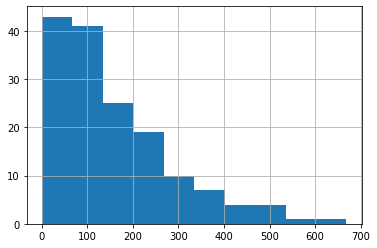

In [11]:
ultimate_plan_data = full_data.query('plan == "ultimate"')
surf_plan_data = full_data.query('plan == "surf"')

ultimate_plan_mins = ultimate_plan_data['avg_duration_per_month']
ultimate_plan_mins_variation = np.var(ultimate_plan_mins)
print('Ultimate plan\n______________________________')
print('\nminutes \nmean:', ultimate_plan_mins.mean(), '\nvariance:', ultimate_plan_mins_variation, '\nstandard deviation:', np.sqrt(ultimate_plan_mins_variation))

ultimate_plan_mins.hist()

Ultimate plan
______________________________

minutes 
mean: 162.7533844580777 
variance: 18086.267558300908 
standard deviation: 134.48519456914545


<AxesSubplot:>

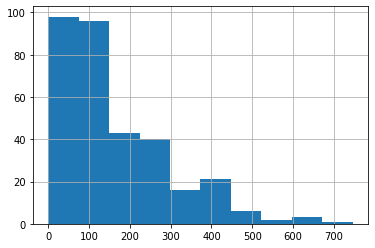

In [12]:
surf_data = full_data.query('plan == "surf"')
surf_plan_mins = surf_data['avg_duration_per_month']
surf_mins_variation = np.var(surf_plan_mins)
print('Ultimate plan\n______________________________')
print('\nminutes \nmean:', surf_plan_mins.mean(), '\nvariance:', surf_mins_variation, '\nstandard deviation:', np.sqrt(surf_mins_variation))

surf_plan_mins.hist()

O cliente que tem uma duração média de chamada no mês é muito semelhante entre o plano `ultimate` e o plano de `surf`, tendo médias e desvios padrão muito próximos. Os gráficos têm um intervalo semelhante de 0 a 700 minutos. A mediana para ambos fica entre 100-200 minutos, e a distribuição para cada um é desviada para a direita.

Ultimate plan
______________________________

texts 
mean: 17.06881313131313 
variance: 279.2679394162585 
standard deviation: 16.711311720396413


<AxesSubplot:>

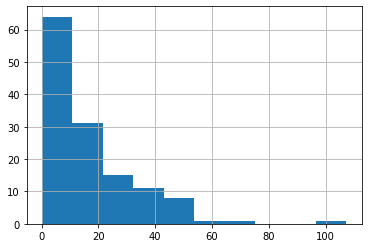

In [13]:
ultimate_data = full_data.query('plan == "ultimate"')
ultimate_plan_texts = ultimate_data['avg_texts_per_month']
ultimate_text_variation = np.var(ultimate_plan_texts)
print('Ultimate plan\n______________________________')
print('\ntexts \nmean:', ultimate_plan_texts.mean(), '\nvariance:', ultimate_text_variation, '\nstandard deviation:', np.sqrt(ultimate_text_variation))

ultimate_plan_texts.hist()

Ultimate plan
______________________________

texts 
mean: 15.127777777777778 
variance: 243.26319958847733 
standard deviation: 15.596897114121044


<AxesSubplot:>

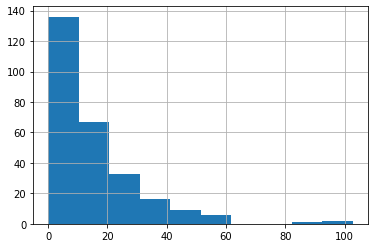

In [14]:
surf_plan_texts = surf_data['avg_texts_per_month']
surf_text_variation = np.var(surf_plan_texts)
print('Ultimate plan\n______________________________')
print('\ntexts \nmean:', surf_plan_texts.mean(), '\nvariance:', surf_text_variation, '\nstandard deviation:', np.sqrt(surf_text_variation))

surf_plan_texts.hist()

Os dados de texto médio por mês do cliente também se assemelham bastante juntamente com as médias e desvios padrão. Os usuários do plano `Ultimate` têm uma média um pouco maior de cerca de 2 textos por mês. Ambos os gráficos têm um intervalo semelhante entre 0 a 50 textos por mês, com alguns valores discrepantes em potencial. As medianas são aproximadamente as mesmas em cerca de 10 textos por mês, e a distribuição para ambos os planos é distorcida para a direita.

Ultimate plan
______________________________

volume of data 
mean: 6578.866125265393 
variance: 30559701.78816901 
standard deviation: 5528.083012054813


<AxesSubplot:>

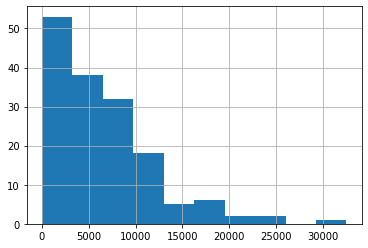

In [15]:
ultimate_plan_mb = ultimate_data['avg_mb_per_month']
ultimate_mb_variation = np.var(ultimate_plan_mb)
print('Ultimate plan\n______________________________')
print('\nvolume of data \nmean:', ultimate_plan_mb.mean(), '\nvariance:', ultimate_mb_variation, '\nstandard deviation:', np.sqrt(ultimate_mb_variation))

ultimate_plan_mb.hist()

Surf plan
______________________________

volume of data 
mean: 6537.695765562249 
variance: 24710213.623550043 
standard deviation: 4970.936895953321


<AxesSubplot:>

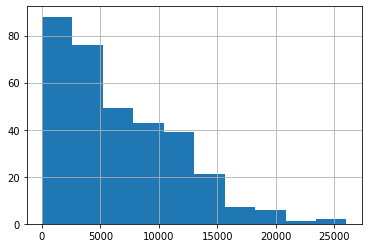

In [16]:
surf_plan_mb = surf_data['avg_mb_per_month']
surf_mb_variation = np.var(surf_plan_mb)
print('Surf plan\n______________________________')
print('\nvolume of data \nmean:', surf_plan_mb.mean(), '\nvariance:', surf_mb_variation, '\nstandard deviation:', np.sqrt(surf_mb_variation))

surf_plan_mb.hist()

Os dados do usuário para o volume médio de dados usados por mês são aproximadamente os mesmos para ambos os planos. A média é de aproximadamente 6.500 Mb usados por mês, mas uma diferença importante é que a variância e o desvio padrão são significativamente maiores no plano `Ultimate`, o que significa que a dispersão para os usuários do plano `Ultimate` é maior do que o plano de `Surf`. Os gráficos têm intervalos semelhantes de 0 a 25.000 Mb usados por mês, com o plano `Ultimate` tendo mais discrepâncias em potencial. Novamente ambos os planos são desviados para a direita.

Usaremos os dados para testar a hipótese.

No primeiro caso, a hipótese nula será o lucro médio dos usuários dos planos de ligação `Ultimate` e `Surf` não diferem. A hipótese alternativa é que o lucro médio dos usuários dos planos de ligação `Ultimate` e `Surf` diferem.

In [17]:
ultimate_profit_avg = ultimate_data['monthly_profit']
surf_profit_avg = surf_data['monthly_profit']

alpha = 0.05

results = st.ttest_ind(ultimate_profit_avg, surf_profit_avg)

print('p-value:', results.pvalue)

if(results.pvalue<alpha):
    print('A hipótese nula foi rejeitada')
else:
    print('A hipótese nula não pode ser rejeitada')

p-value: 2.5448576563679514e-206
A hipótese nula foi rejeitada


Com base nos resultados, concluímos que há evidências estatisticamente significativas de que o lucro médio dos usuários dos planos de ligação `Ultimate` e `Surf` diferem.

O segundo caso determinará se o lucro médio dos usuários na área de NY-NJ é diferente dos usuários de outras regiões. A hipótese nula será que o lucro médio dos usuários na área de NY-NJ não é diferente dos usuários de outras regiões, e a hipótese alternativa difinirá o completo oposto.

In [18]:
NY_NJ_profit_avg = full_data.query('city.str.contains("NY") | city.str.contains("NJ")', engine='python')['monthly_profit']
others_profit_avg = full_data.query('city.str.contains("NY") == 0 & city.str.contains("NJ") == 0', engine='python')['monthly_profit']

alpha = 0.05

results = st.ttest_ind(NY_NJ_profit_avg, others_profit_avg)

print('p-value:', results.pvalue)

if(results.pvalue<alpha):
    print('A hipótese nula foi rejeitada')
else:
    print('A hipótese nula não pode ser rejeitada')

p-value: 0.07715179347408789
A hipótese nula não pode ser rejeitada


Baseando-se no teste, concluimos que há evidências estatisticamente significativas de que o lucro médio dos usuários na área de NY-NJ não é diferente dos usuários de outras regiões.

## Conclusão

Com todas as informações coletas e filtradas durante o processo pudemos obter o necessário para determinar os lucros mensais médios dos clientes. Após mesclar os dataframes fomos capazes de processar os dados para plotar gráficos que contêm as distribuições de comportamento do cliente. Com base nisso, concluímos que os planos de dados não se distingui radicalmente e tiveram médias parecidas para cada fonte. Após testar as hipóteses observamos que não conseguimos concluir as diferenças entre o lucro médio de diferentes planos e o lucro médio de diferentes regiões.